# Search for datasets coincident with a list of points

__This notebook is an expanded version of `tutorial_02_demo.ipynb`, containing some exercises to practice some of the concepts and methods described here.__

A physical oceanographer is interested in obtaining ICESat-2 sea ice height in Baffin Bay close to ARGO floats.  This kind of search could be done using EarthData search.  First by getting the coordinates of the ARGO floats and then typing the coordinates into the search box.  However, this workflow could get tedious, especially if the search needs to be repeated.  Furthermore, the search is not easily made reproduceable.  Reproduceability is critical if you need to completely redo your analysis yourself, or if others want to recreate your reanalysis.  By capturing the search in code, either in a notebook such as this one or in a script, you or anyone else can reproduce the search and any subsequent analysis.

Similar use cases would be to select data coincident with a cruise, with ice mass balance buoys in Arctic and Antarctic, or the MOSAIC experiment.

In this tutorial, we will use python but a similar approach could be taken using R, Matlab or IDL.  You will convert a list of coordinates for ARGO floats into a GeoJSON file; use this file to write a query to the CMR API and order data.  Finally we will visualize the data to produce a plot siilar to the one below.

<img src="intro_image.png">

## Learning objectives
1. Convert a list of coordinates into a GeoJSON file.
2. Write a query for the NASA CMR API.
3. Submit the query and interpret the response.
4. Order datasets returned by the query.
5. Visualize the results.

## Import modules

The Python ecosystem is organized into modules.  A module must be imported before the contents of that modules can be used.  It is good practice to import modules in the first code cell of a notebook or at the top of your script.  Not only does this make it clear which modules are being used, but it also ensures that the code fails at the beginning if one of the modules is not installed rather half way through after crunching a load of data.

For some modules, it is common practice to shorten the module names according to accepted conventions.  For example, the plotting module `matplotlib.pyplot` is shortened to `plt`.  It is best to stick to these conventions rather than making up your own short names so that people reading your code see immediately what you are doing. 

In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd
import geopandas as gpd

import tutorial_cmr

## Convert a list of coordinates to a GeoJSON file

There are two steps to this: first, read the list of coordinates; second, write cordinates as a GeoJSON file.  

We'll use `pandas` to read the file containing the coordinates becaue it offers a simple way to read comma separated text files (`csv`).  The `GeoPandas` package, which extends `pandas` into the spatial realm is then used to write a GeoJSON file.

_If you are not familiar with `pandas` it's worth exploring._

### What is GeoJSON?

[__GeoJSON__](https://geojson.org/) is an open standard data format for simple geographic data and non-spatial attributes, such as points, lines and polygons. 

Before reading a file, it is always useful to have a look at it.  Especially text files because they might not be formated nicely or have some strange characters that you need to deal with. If you are working in JupyterLab you can use the unix command `head` from within a notebook (see below) or in a terminal, even if you are running Mac or Windows.  If you running Windows and not working in JupyterLab, you can open the file in a text editor such as `notepad` but make sure you don't save the file and __do not use a word processor__ it will likely change the file.

_I use `head`.  In Jupyter notebooks the `!` at the beginning of a line allows a shell command to be run_

In [2]:
!head argo_locations.csv

Date    	Latitude	Longitude	FloatID	DAC
 20201101	58.033	-47.105	6901170	bodc
 20201101	56.267	-54.291	4902510	meds
 20201101	57.178	-53.264	4902509	meds
 20201101	57.389	-51.571	4902505	meds
 20201101	59.921	-50.340	4902471	meds
 20201101	54.456	-50.419	3901669	coriolis
 20201101	54.339	-47.566	6901191	bodc
 20201101	66.973	-57.687	6902952	coriolis
 20201101	58.859	-58.043	6901194	bodc


We can learn a number of things from the file listing above.  The file has a header row, and the columns are separated by whitespace.  This whitespace could be multiple spaces or tabs.  `pandas.read_csv` can deal with this if the `delim_whitespace` keyword argument is set to true.  Setting `header=0` tells `pandas.read_csv` to use row 0 as column headings.

In [3]:
argo_df = pd.read_csv('argo_locations.csv', header=0, delim_whitespace=True)  # df is shorthand for Dataframe
argo_df.head()  # df.tail() prints the last few lines

,Date,Latitude,Longitude,FloatID,DAC
0,20201101,58.033,-47.105,6901170,bodc
1,20201101,56.267,-54.291,4902510,meds
2,20201101,57.178,-53.264,4902509,meds
3,20201101,57.389,-51.571,4902505,meds
4,20201101,59.921,-50.340,4902471,meds


Converting the `pandas.Dataframe` to a GeoPandas dataframe is done simply using the `geopandas.GeoDataFrame` method.  We need to tell this method which columns of `argo_df` contain spatial geometry information.  Note, in the argument to `geopandas.points_from_xy`, the x coordinate is _Longitude_ and the y coordinate is _Latitude_.

To complete the geographic information, we need to specify the coordinate reference system (CRS).  Because we use latitude and longitude, the data are _unprojected_.  However, latitude and longitude are on the World Geodetic System 1984 ellipsoid (WGS84) datum.  We set the CRS using an EPSG code.  EPSG stands for European Petroleum Survey Group.  The code for WGS84 is 4326.

In [4]:
argo_gdf = gpd.GeoDataFrame(argo_df, geometry=gpd.points_from_xy(argo_df.Longitude, argo_df.Latitude), crs="EPSG:4326")
argo_gdf.head()

,Date,Latitude,Longitude,FloatID,DAC,geometry
0,20201101,58.033,-47.105,6901170,bodc,POINT (-47.10500 58.03300)
1,20201101,56.267,-54.291,4902510,meds,POINT (-54.29100 56.26700)
2,20201101,57.178,-53.264,4902509,meds,POINT (-53.26400 57.17800)
3,20201101,57.389,-51.571,4902505,meds,POINT (-51.57100 57.38900)
4,20201101,59.921,-50.340,4902471,meds,POINT (-50.34000 59.92100)


`argo_gdf` looks similar to `argo_df` but it has a __geometry__ column.  This is the magic sauce that turns a dataframe into a geospatial dataframe.

It's worth taking a quick look at the GeoJSON object, if only to take the mystery out of it.  You can see that the object contains a collection of _features_.  Each of these _features_ is information about an ARGO float on a give date.  The column entries (_attributes_) for each float are listed as properties and the spatial information is the _geometry_. 

In [5]:
# print(json.dumps(json.loads(argo_gdf.to_json()), indent=1))

`argo_gdf` can be written to a GeoJSON formatted file using the `to_file` method.

In [6]:
argo_gdf.to_file('argo-data.geojson', driver='GeoJSON')

While we've gone through this step by step, coordinate data can be converted from a text file to a GeoJSON file in three lines of code.
```
argo_df = pd.read_csv('argo_locations.csv', header=0, delim_whitespace=True)
argo_gdf = gpd.GeoDataFrame(argo_df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), )
argo_gdf.to_file('argo-data.geojson', driver='GeoJSON')
```

## Submit a query via the CMR API
_CMR_ is the __Common Metadata Repository__.  It is a metadata system that catalogs Earth Science data and associated service metadata records. These metadata records can be discovered and accessed through programmatic interfaces leveraging standard protocols and an Application Programming Interface or API.  An API takes a request or set of instructions from a device, your computer, to a service, in this case NASA's CMR and returns a response.  This short [video](https://www.youtube.com/watch?v=s7wmiS2mSXY) gives a nice explanation of APIs.

There are a number of python modules that provide a stripped down interface with the CMR API:
- [`pyCMR`](https://github.com/nasa/pyCMR);
- [`python-cmr`](https://github.com/jddeal/python-cmr);
- [`icepyx`](https://github.com/icesat2py/icepyx). 

`pyCMR` and `python-cmr` search the CMR.  `icepyx` is a tool designed specifically for ICESat-2 data.  However, these modules do not allow access to all of the CMR API functionality, so we have written an ad-hoc module `tutorial_cmr` for search and download just for these tutorials.  `tutorial_cmr` is imported along with the other modules at the top of this notebook.  The modules uses the `requests` module.  Useful overview of `requests` can be found [here](https://requests.readthedocs.io/en/master/user/quickstart/) and [here](https://realpython.com/python-requests/).  Take a look at `tutorial_cmr.py` if you want to find out more about how we use `requests` with the CMR API. 

__Hint:__ In Python, to find out how to use a function you can type `help(<function_name>)` or `<function_name>?`.  If the function has a _docstring_ (__All functions should have one__), it will be printed. 

In [7]:
help(tutorial_cmr.search_granules)

Help on function search_granules in module tutorial_cmr:

search_granules(search_parameters, geojson=None, output_format='json')
    Performs a granule search
    
    :search_parameters: dictionary of CMR search parameters
    :geojson: filepath to GeoJSON file for spatial search
    :output_format: select format for results https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#supported-result-formats
    
    :returns: if hits is greater than 0, search results are returned in chosen output_format, otherwise returns None.



`tutorial_cmr.search_granules` takes a dictionary of [CMR search parameters](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#granule-search-by-parameters) and an optional GeoJSON file if you specify a spatial search.

In this example, we are searching for version 3, ICESat-2 sea ice surface height, which has the `short_name` ATL07, for the first three days in January 2020 that corresponds with the locations of our selected ARGO floats.

In [8]:
search_parameters = {
    "short_name": "ATL07", 
    "version": "003",  # CMR searches for most recent version
    "temporal": "2020-01-01T00:00:00Z,2020-01-03T23:59:59Z",
}
search_results = tutorial_cmr.search_granules(search_parameters, geojson="argo-data.geojson")

Found 3 granules


We can find 3 granules that match these criteria.  By default, `tutorial_cmr.search_granules` returns a decoded JSON object.  This is a Python dictionary object.

Python dictionaries are collections of `key: value` pairs.  Values can be numbers, strings, dictionaries, lists and other Python objects.  Values in dictionaries are accessed with the following syntax

```
dictionary[key]
```

There is lots of useful information in the JSON structure returned from `tutorial_cmr.search_granules`.  The exercise version of this notebook has exercises to familiarize you with navigating the JSON structure.

Fields of immediate interest are likely to be date and the polygon containing the granule, as well as the url for H5 file containing the actual data.  `tutorial_cmr` contains helper functions to access time and spatial information, and to print the url for the H5 file for each granules.

In [9]:
tutorial_cmr.print_urls(search_results)

https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.01/ATL07-01_20200101094756_00870601_003_02.h5
https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.01/ATL07-01_20200101094756_00870601_003_02.iso.xml
https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.02/ATL07-01_20200102092216_01020601_003_02.h5
https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.02/ATL07-01_20200102092216_01020601_003_02.iso.xml
https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.03/ATL07-01_20200103213055_01250601_003_02.h5
https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.03/ATL07-01_20200103213055_01250601_003_02.iso.xml


It is also useful to check that the granules are for the correct domain.  `tutorial_cmr.get_extent_and_date` returns a GeoJSON Dataframe that can be used to plot the spatial extent of the granules.  See `tutorials_cmr.py` on how this is done.

In [10]:
results_gdf = tutorial_cmr.results_to_geodataframe(search_results)
results_gdf

,producer_granule_id,time_start,time_end,polygons,geometry
0,ATL07-01_20200101094756_00870601_003_02.h5,2020-01-01T10:07:11.863Z,2020-01-01T10:16:28.584Z,[[73.42182315722476 116.48525745715948 86.5800...,"POLYGON ((116.48526 73.42182, -18.27500 86.580..."
1,ATL07-01_20200102092216_01020601_003_02.h5,2020-01-02T09:32:52.721Z,2020-01-02T09:47:23.005Z,[[40.43349307986964 129.75247961591882 59.4900...,"POLYGON ((129.75248 40.43349, 126.70341 59.490..."
2,ATL07-01_20200103213055_01250601_003_02.h5,2020-01-03T21:43:14.832Z,2020-01-03T21:59:22.170Z,[[46.97915537757497 -54.38557216740003 66.0220...,"POLYGON ((-54.38557 46.97916, -58.15664 66.022..."


We can use `cartopy` and `matplotlib` to plot the ARGO float locations and granule extent polygons.  If you don't know these modules, it is worth learning them because they are very useful.

One thing to note is that we change the projection of `results_gdf` using the `to_crs()` method.  By default polygon coordinates are unprojected latitudes and longitudes on the WGS84 datum.  Many, but not all, plotting routines have trouble plotting polygons and lines that cross the poles.  Re-projecting the geometries to a projected grid, such as the [NSIDC North Polar Stereographic grid](https://nsidc.org/data/polar-stereo/ps_grids.html), avoids this issue.

<GeoAxesSubplot:>

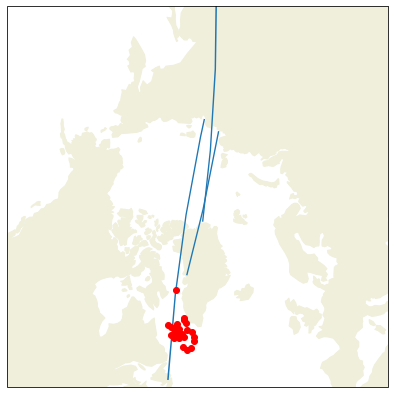

In [11]:
# Define NSIDC North Polar Stereographic projection
NSIDCNorthPolarStereo = ccrs.Stereographic(central_longitude=-45., central_latitude=90., globe=None)
map_extent = [-5000000.0, 5000000.0, -5000000.0, 5000000.0]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=NSIDCNorthPolarStereo)
ax.set_extent(map_extent, NSIDCNorthPolarStereo)
ax.add_feature(cfeature.LAND)

results_gdf.to_crs("EPSG:3413").plot(ax=ax, transform=NSIDCNorthPolarStereo)
argo_gdf.to_crs("EPSG:3413").plot(c="r", ax=ax, transform=NSIDCNorthPolarStereo)

In [12]:
results_gdf

,producer_granule_id,time_start,time_end,polygons,geometry
0,ATL07-01_20200101094756_00870601_003_02.h5,2020-01-01T10:07:11.863Z,2020-01-01T10:16:28.584Z,[[73.42182315722476 116.48525745715948 86.5800...,"POLYGON ((116.48526 73.42182, -18.27500 86.580..."
1,ATL07-01_20200102092216_01020601_003_02.h5,2020-01-02T09:32:52.721Z,2020-01-02T09:47:23.005Z,[[40.43349307986964 129.75247961591882 59.4900...,"POLYGON ((129.75248 40.43349, 126.70341 59.490..."
2,ATL07-01_20200103213055_01250601_003_02.h5,2020-01-03T21:43:14.832Z,2020-01-03T21:59:22.170Z,[[46.97915537757497 -54.38557216740003 66.0220...,"POLYGON ((-54.38557 46.97916, -58.15664 66.022..."


We have already seen how to get a list of urls for the data files returned by search using `tutorial_cmr.filter_urls`.  To download the files from NSIDC we use `tutorial_cmr.download`.  

Downloading files requires your EarthData username and password.  You should __never__ store login credentials in a notebook, script or program.  One way around this is to create a `.netrc` (on Unix/Linux platforms) or `_netrc` (on Windows) files.  On Unix/Linux machines, is `.netrc` stored in your home directory.  A simple `.netrc` file with a single entry for EarthData will look like:
```
machine urs.earthdata.nasa.gov login <your_username> password <your_password>
```

On a Windows machine it is kept in `C:\Users\"username"` and has the following format:
```
machine urs.earthdata.nasa.gov
login <your_username>
password <your_password>
```

`tutorial_cmr.download` first looks for a `netrc` file.  If it doesn't find one, it will prompt for a username and password.  So don't worry about setting one up right now.  However, it is worth doing so in the future.

In [13]:
%%time
# %%time is a magic command that measured the execution time of a cell
urls = tutorial_cmr.filter_urls(search_results)
for i, url in enumerate(urls):
    print(f"{i} {url}")
#tutorial_cmr.download(urls[4:])  # Downloads the last two files in urls - urls[4:] "slices" array from 4th element to end of array
tutorial_cmr.download2(urls[4:])  # As above but uses alternative download function so it works on binderhub

0 https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.01/ATL07-01_20200101094756_00870601_003_02.h5
1 https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.01/ATL07-01_20200101094756_00870601_003_02.iso.xml
2 https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.02/ATL07-01_20200102092216_01020601_003_02.h5
3 https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.02/ATL07-01_20200102092216_01020601_003_02.iso.xml
4 https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.03/ATL07-01_20200103213055_01250601_003_02.h5
5 https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL07.003/2020.01.03/ATL07-01_20200103213055_01250601_003_02.iso.xml
1/2: ATL07-01_20200103213055_01250601_003_02.h5
2/2: ATL07-01_20200103213055_01250601_003_02.iso.xml
CPU times: user 2.62 s, sys: 3.03 s, total: 5.64 s
Wall time: 20.2 s


# Read ICESat-2 ATL07 granule using `xarray`

ICESat-2 data are served in _Hierachical Data Format version 5_ (HDF5) files.  You can find information about HDF5 from this [NASA page](https://earthdata.nasa.gov/esdis/eso/standards-and-references/hdf5).  Information about the structure of ATL07 HDF5 files can be found [here](https://nsidc.org/data/ATL07).

You can view the structure of any HDF5 file using `h5dump -H`, which displays the header information of the file.  `h5dump -n` returns a list of file contents. `h5dump` is a powerful tool that can be used to explore a HDF5 file and subset the file.  The full range of options for `h5dump` can be seen by typing

`h5dump -h`

__Note:__ _`h5dump` is a shell command.  To run a shell command from a Jupyter Notebook type `!` at the beginning of the line.

Running the cell below displays the header information of a HDF5.  The output from `h5dump -H` can be long.

__Hint:__ _In Jupyter Notebooks Clicking on the blue vertical bar to the left of an output cell, collapses that cell.  You might need to click on the output cell contents to see the vertical blue line_ 

In [14]:
!h5dump -n ATL07-01_20200103213055_01250601_003_02.h5

HDF5 "ATL07-01_20200103213055_01250601_003_02.h5" {
FILE_CONTENTS {
 group      /
 group      /METADATA
 group      /METADATA/AcquisitionInformation
 group      /METADATA/AcquisitionInformation/lidar
 group      /METADATA/AcquisitionInformation/lidarDocument
 group      /METADATA/AcquisitionInformation/platform
 group      /METADATA/AcquisitionInformation/platformDocument
 group      /METADATA/DataQuality
 group      /METADATA/DataQuality/CompletenessOmission
 group      /METADATA/DataQuality/DomainConsistency
 group      /METADATA/DatasetIdentification
 group      /METADATA/Extent
 group      /METADATA/Lineage
 group      /METADATA/Lineage/ANC02-02
 group      /METADATA/Lineage/ANC15
 group      /METADATA/Lineage/ANC19
 group      /METADATA/Lineage/ANC25-07
 group      /METADATA/Lineage/ANC26-07
 group      /METADATA/Lineage/ANC31
 group      /METADATA/Lineage/ANC36-07
 group      /METADATA/Lineage/ANC38-07
 group      /METADATA/Lineage/ATL03
 group      /METADATA/Lineage/ATL09
 group

ATL07 data can be read into any number of python objects, including `numpy` arrays and `pandas` Dataframes.  I'm a big fan of `xarray`, which is a python package designed to work with multi-dimensional arrays.  See the [xarray website](http://xarray.pydata.org/en/stable/) for more information.  You can find examples of using `pandas` to work with ICESat-2 data in `04_melt_pond/tutorial_helper_functions.py`.

`xarray` creates Dataset objects that have a similar structure to NetCDF files.  Variables can have dimensions and coordinates, and attributes.  _Pandas_ does not have this feature.

The function below reads 

In [15]:
import h5py
import xarray as xr

def parse_attrs(attrs):
    """Unpacks HDF5 attributes"""
    result = {}
    for k, v in attrs.items():
        if isinstance(v, np.bytes_):
            result[k] = v.astype(str)
        elif k == "_FillValue":
            result[k] = v[0]                
        else:
            result[k] = v
    return result


def read_atl07(filepath, beam='gt2l'):
    """Read ATL07 (Sea Ice Height)"""
    f = h5py.File(filepath, 'r')
    ds = xr.Dataset({
        'height': (['x'],
                   f[beam]['sea_ice_segments']['heights']['height_segment_height'][:], 
                   parse_attrs(f[beam]['sea_ice_segments']['heights']['height_segment_height'].attrs)), 
        'surface_type': (['x'], 
                         f[beam]['sea_ice_segments']['heights']['height_segment_type'][:],
                         parse_attrs(f[beam]['sea_ice_segments']['heights']['height_segment_type'].attrs)), 
        'segment_length': (['x'], 
                           f[beam]['sea_ice_segments']['heights']['height_segment_length_seg'][:],
                           parse_attrs(f[beam]['sea_ice_segments']['heights']['height_segment_length_seg'].attrs)), 
        'segment_quality': (['x'], 
                            f[beam]['sea_ice_segments']['heights']['height_segment_quality'][:],
                            parse_attrs(f[beam]['sea_ice_segments']['heights']['height_segment_quality'].attrs)), 
        'geoseg_beg': (['x'], 
                       f[beam]['sea_ice_segments']['geoseg_beg'][:],
                       parse_attrs(f[beam]['sea_ice_segments']['geoseg_beg'].attrs)), 
        'geoseg_end': (['x'], 
                       f[beam]['sea_ice_segments']['geoseg_end'][:],
                      parse_attrs(f[beam]['sea_ice_segments']['geoseg_end'].attrs)), 
        'latitude': (['x'], 
                     f[beam]['sea_ice_segments']['latitude'][:],
                    parse_attrs(f[beam]['sea_ice_segments']['latitude'].attrs)), 
        'longitude': (['x'], 
                      f[beam]['sea_ice_segments']['longitude'][:],
                     parse_attrs(f[beam]['sea_ice_segments']['longitude'].attrs)),
        'segment_id': (['x'], 
                       f[beam]['sea_ice_segments']['height_segment_id'][:],
                       parse_attrs(f[beam]['sea_ice_segments']['height_segment_id'].attrs)),
        },
        coords={
            'x': (['x'], 
                  f[beam]['sea_ice_segments']['seg_dist_x'][:],
                  parse_attrs(f[beam]['sea_ice_segments']['seg_dist_x'].attrs)),
        })
    return ds

We'll read `ATL07-01_20200103213055_01250601_003_02.h5`.  This is the ICESat-2 track that crosses Baffin Bay.

`read_atl07` returns an `xarray.Dataset` object.  If you are familiar with NetCDF, you'll notice that the structure of the Dataset is similar to a NetCDF file with dimensions, coordinates and variables.  `read_atl07` is a custom function to read an ATL07 granule for this tutorial.  If you want to read different variables, you can easily modify `read_atl07` to read those variables. 

In [16]:
ds = read_atl07('ATL07-01_20200103213055_01250601_003_02.h5')
ds

<xarray.Dataset>
Dimensions:          (x: 315860)
Coordinates:
  * x                (x) float64 5.282e+06 5.283e+06 ... 1.21e+07 1.21e+07
Data variables:
    height           (x) float32 -0.16052705 -0.13317138 ... -0.067724966
    surface_type     (x) int8 1 1 1 1 1 1 1 1 1 1 1 1 ... 7 7 7 7 7 7 7 7 7 7 1
    segment_length   (x) float32 462.55136 449.79874 ... 482.6062 499.78897
    segment_quality  (x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    geoseg_beg       (x) int32 263417 263465 263470 ... 603834 603836 603839
    geoseg_end       (x) int32 263440 263488 263490 ... 603857 603860 603864
    latitude         (x) float64 47.44 47.45 47.45 47.45 ... 71.5 71.5 71.49
    longitude        (x) float64 -54.2 -54.2 -54.2 -54.2 ... 129.9 129.9 129.9
    segment_id       (x) int32 1 2 3 4 5 ... 315856 315857 315858 315859 315860

Sea ice surface height can be plotted using the following code. Using the `xarray` plot method automatically labels the x and y axes of the plot.

Even though the ICESat-2 ground track crosses Baffin Bay, there are missing height values.  This is because ATL07 sea ice height is only processed for returns with > 15% ice concentration. 

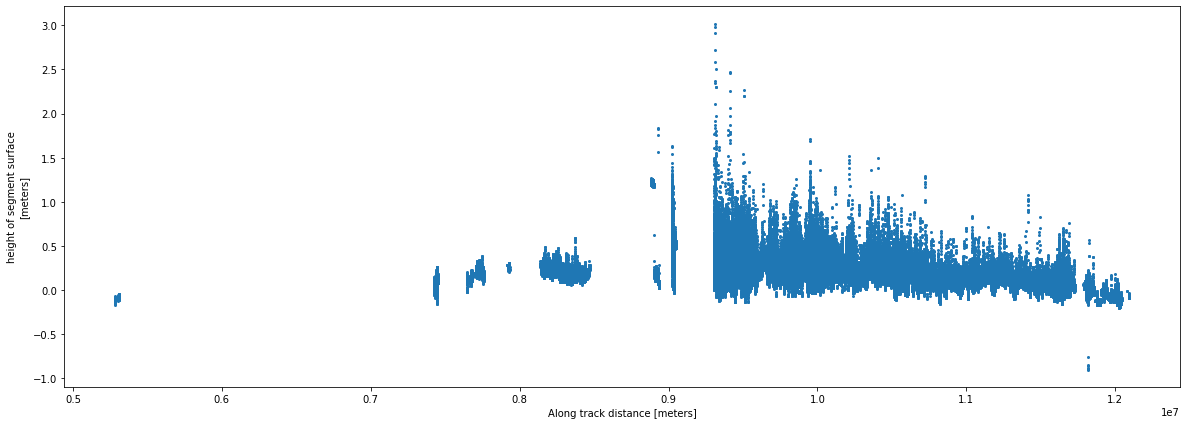

In [17]:
fig, ax = plt.subplots(figsize=(20,7))
ds.height.plot(ax=ax, linestyle='', marker='o', markersize=2)

It is useful to see surface height with respect to other parameters; for example `segment_quality` and `surface_type`.  Unfortunately, `xarray` doesn't have this facility but we can use `matplotlib` to show these features.

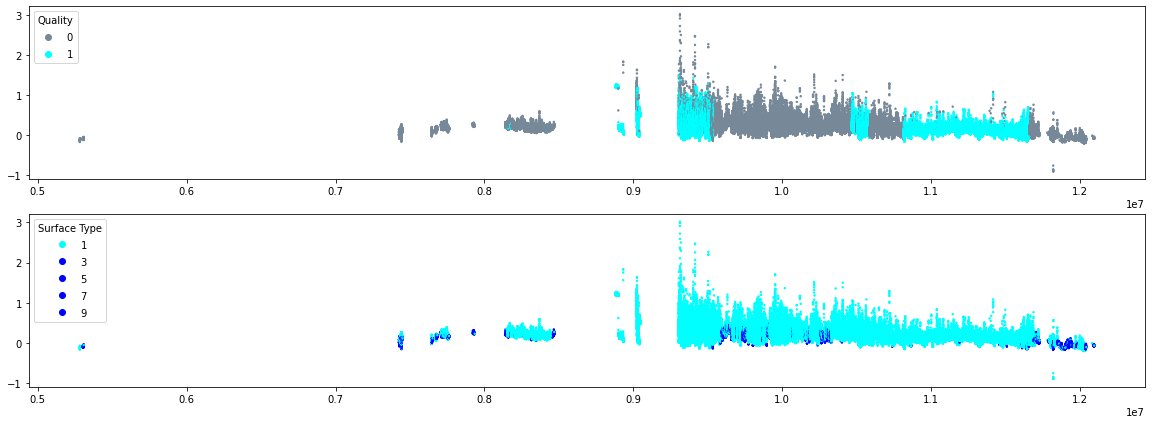

In [18]:
quality_cmap = ListedColormap(['lightslategray','cyan'])
surface_cmap = ListedColormap(['slategray', 'cyan', 'blue'])

bounds = [-0.5, 0.5, 1.5, 9.5]
surface_norm = BoundaryNorm(bounds, ncolors=3, clip=True)

fig, ax = plt.subplots(2, 1, figsize=(20,7))
quality_plot = ax[0].scatter(ds.x, ds.height, c=ds.segment_quality, cmap=quality_cmap, s=2)
quality_legend = ax[0].legend(*quality_plot.legend_elements(), loc="upper left", title="Quality")

surface_plot = ax[1].scatter(ds.x, ds.height, c=ds.surface_type, cmap=surface_cmap, norm=surface_norm, s=2)
surf_handles, surf_labels = surface_plot.legend_elements()
surface_legend = ax[1].legend(surf_handles, surf_labels,  #["Cloud covered", "Other", "Lead"], 
                              loc="upper left", title="Surface Type")


The plot legends show the values of flag for `segment_quality` and `surface_type`.  You can access the meanings for these flags in the attributes of each variable.

Attributes for each variable in an `xarray.Dataset` are accessed by `ds.variable_name.attrs`.  This is a dictionary.  The `flag_values` attribute is an array of integers.  However, `flag_meanings` is a string of meanings.  This string needs to be split using the `.split()` string method.  The resulting array of strings corresponding to each flag can be joined (or __zipped__) with the flag values and printed out.

In [19]:
for flag_value, flag_meaning in zip(ds.surface_type.attrs['flag_values'], ds.surface_type.attrs['flag_meanings'].split()):
    print(f"{flag_value} {flag_meaning}")

0 cloud_covered
1 other
2 specular_lead_low_w_bkg
3 specular_lead_low
4 specular_lead_high_w_bkg
5 specular_lead_high
6 dark_lead_smooth_w_bkg
7 dark_lead_smooth
8 dark_lead_rough_w_bkg
9 dark_lead_rough


We can also plot surface height on a map.  We could plot the whole Arctic but because we are interested in sea ice height in Baffin Bay, close to the ARGO floats, we'll "zoom" in on this area.  I want to center the plot on the ARGO floats.  The code below finds the bounding box of the floats using the `total_bounds` method of the `argo_gdf` `geopandas` object.  Then with a little trial and error, I have chosen a distance `dx` and `dy` around this center point.  I then set `baffin_extent`.

In [20]:
bounds = argo_gdf.to_crs("EPSG:3413").total_bounds  # Returns [minx, miny, maxx, maxy]
bounds

array([ -779876.48098809, -4031658.83368765,   -89920.12051665,
       -2465519.68498921])

In [21]:
xcenter = 0.5 * (bounds[0] + bounds[2])
ycenter = 0.5 * (bounds[1] + bounds[3])
dx = 1750000.
dy = 2000000.

baffin_extent = [xcenter-dx, xcenter+dx, ycenter-dy, ycenter+dy]

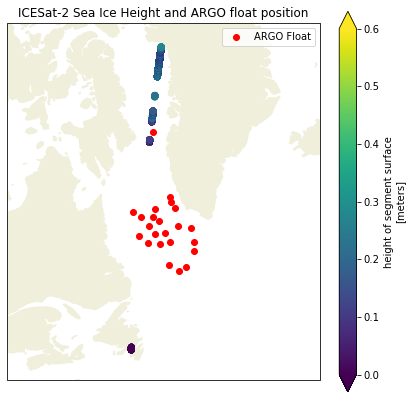

In [22]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=NSIDCNorthPolarStereo)
ax.set_extent(baffin_extent, NSIDCNorthPolarStereo)
ax.add_feature(cfeature.LAND)
ax.set_title("ICESat-2 Sea Ice Height and ARGO float position")

ds.plot.scatter('longitude', 'latitude', hue='height', ax=ax, transform=ccrs.PlateCarree(), vmin=0., vmax=.6)
argo_gdf.to_crs("EPSG:3413").plot(c="r", ax=ax, transform=NSIDCNorthPolarStereo, label='ARGO Float')

ax.legend()